<a href="https://colab.research.google.com/github/FaQ2108/Trading-Algoritmico-con-SmallCaps/blob/main/Estrategia1_(ideal_y_optimizada).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtest vectorizado y optimización de parametros con Pandas.

---

Este notebook está diseñado para adaptar y mejorar el contenido del "Webinar 2 - Backtest con Pandas v 2.ipynb", utilizando datos obtenidos de una base de datos SQLite. La finalidad es realizar pruebas de retroceso (backtesting) sobre los datos históricos de precios de acciones de baja capitalización (small caps) almacenados en dicha base de datos, implementando técnicas de análisis técnico y estrategias de trading.

---

## **Objetivos del Notebook:**

* **Conexión y Extracción de Datos:**

Conectar a la base de datos SQLite y extraer los datos históricos necesarios para el análisis.

* **Cálculo de Indicadores Técnicos:**

Calcular indicadores técnicos esenciales, como medias móviles, utilizando las bibliotecas pandas y numpy.

* **Generación de Señales de Trading:**

Generar señales de compra y venta basadas en los indicadores calculados para evaluar la estrategia de trading.

* **Evaluación de la Estrategia:**

Realizar el backtest utilizando los datos extraídos y analizar el rendimiento de la estrategia de trading.

* **Visualización de Resultados:**

Visualizar los resultados del backtest comparando el rendimiento de la estrategia con el rendimiento del mercado.

## **Metodología**
* **Conexión y Extracción de Datos:**

Utilizar la biblioteca sqlite3 para establecer una conexión con la base de datos SQLite y extraer los datos necesarios.

Convertir los datos extraídos en un DataFrame de Pandas para facilitar su manipulación y análisis.

* **Cálculo de Indicadores Técnicos:**

Implementar el cálculo de medias móviles simples (SMA) de diferentes periodos para identificar tendencias en los datos de precios.

* **Generación de Señales de Trading:**

Crear una columna de señales que indique cuándo comprar o vender basándose en los cruces de las medias móviles calculadas.

* **Evaluación de la Estrategia:**

Evaluar el rendimiento de la estrategia de trading calculando los rendimientos diarios y acumulativos, y compararlos con el rendimiento del mercado.

* **Visualización de Resultados:**

Utilizar matplotlib para crear gráficos que muestren el rendimiento acumulativo de la estrategia frente al rendimiento del mercado, facilitando la interpretación de los resultados.

In [ ]:
#SELECTOR DE OPTIMIZACION
optimizacion=False

# IMPORTACIÓN DE MODULOS Y CARGA DE DATOS


In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

La carga de datos en este caso debe realizarse a partir de la base de datos SQLite del proyecto.

Conectar a la Base de Datos SQLite.

In [ ]:
import sqlite3

# Conexión al drive, donde esta la base de datos
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/Proyecto_SmallCaps/BBDD/bbdd historico actualizado/trendvision_alerts_historico.db'
# Ruta al archivo en Google Drive
#file_path = '/content/drive/MyDrive/Proyecto_SmallCaps/BBDD/bbdd_historico_pruebas/trendvision_alerts_historico.db'

# Conexion a base de datos:
conexion = sqlite3.connect(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar las alertas desde la tabla
alerts_query = "SELECT * FROM alerts"
alerts = pd.read_sql_query(alerts_query, conexion)


### Filtrado de Alertas

Este bloque de código filtra las alertas que cumplen con ciertas condiciones:

1. **Condiciones de Filtrado:**
   - **Ranking #1:** Se seleccionan solo las alertas con un ranking de "#1".
   - **Valor de RV mayor a 5:** La alerta debe tener un valor de RV superior a 5.
   - **Volumen de transacciones (one_v) superior a 100,000:** Solo se consideran las alertas con un volumen de transacciones mayor a 100,000.
   - **Rango horario (15:30 - 22:00):** Las alertas solo se filtran si ocurren entre las 15:30 y las 22:00 horas del día. Para esto, se convierte el campo `date` al formato adecuado y se verifica que esté dentro del intervalo de tiempo especificado.

2. **Resultado:**
   - El filtro devuelve las alertas que cumplen todas estas condiciones y se almacena en la variable `filtered_alerts`.

3. **Contabilización:**
   - Finalmente, se imprime el número total de alertas válidas después de aplicar el filtro.

Este código asegura que solo se procesen las alertas relevantes para el análisis posterior, según los criterios establecidos.


### Alternativa 1

In [ ]:
# Filtrar las alertas según las condiciones
filtered_alerts = alerts[
    (alerts['ohlc_downloaded'] == True) &
    (alerts['ranking'] == '#1') &
    (alerts['rv'] > 2) &
    (alerts['one_v'] > 10000) &
    (pd.to_datetime(alerts['date'], format="%Y-%m-%d %H:%M:%S").dt.time >= pd.to_datetime("15:30:00").time()) &
    (pd.to_datetime(alerts['date'], format="%Y-%m-%d %H:%M:%S").dt.time <= pd.to_datetime("22:00:00").time())
].copy()

print(f"Total de alertas válidas: {len(filtered_alerts)}")


Total de alertas válidas: 423


### Alternativa 2

In [ ]:
# Filtrar las alertas según las condiciones
filtered_alerts = alerts[
    (alerts['ohlc_downloaded'] == True) &
    (alerts['ranking'] == '#1') &
    (alerts['rv'] > 2) &
    (alerts['one_v'] > 5000) &
    (pd.to_datetime(alerts['date'], format="%Y-%m-%d %H:%M:%S").dt.time >= pd.to_datetime("15:30:00").time()) &
    (pd.to_datetime(alerts['date'], format="%Y-%m-%d %H:%M:%S").dt.time <= pd.to_datetime("22:00:00").time()) &
    (alerts['change'] > 0) &
    (alerts['price'] >= 0) &
    (alerts['ft'] > 600000) &
    (alerts['mc'] > 8500000) &
    (alerts['mv'] > 150000)
].copy()

print(f"Total de alertas válidas: {len(filtered_alerts)}")

Total de alertas válidas: 73


# Estrategia de trading de rendimiento ideal

El código implementa una estrategia de trading de rendimiento ideal que sigue las siguientes condiciones para cada alerta:

1. **Lectura de la alerta:**
   - Para cada alerta en `filtered_alerts`, se obtiene el **ticker**, **fecha** de la alerta y el **precio de entrada** en el momento de la alerta.

2. **Obtención de datos OHLC:**
   - Se consulta la base de datos para obtener los datos de precios del **mismo ticker** y **día** a partir de la hora de la alerta.

3. **Cálculo del máximo desde la entrada:**
   - Se calcula el **máximo histórico desde el precio de entrada** usando `.cummax()` en la columna `high` de los datos OHLC.

4. **Inicialización de condiciones:**
   - Se establece un **Stop Loss** inicial al 3% por debajo del precio de entrada (precio de entrada * 0.90).
   - Si el precio sube un 20% o más respecto al precio de entrada, el **Stop Loss** se ajusta al 5% por encima del precio de entrada.
   - El **Take Profit** se establece como el máximo del día, es decir, el valor más alto alcanzado en el día desde la entrada.

5. **Recorrido de los datos OHLC:**
   - El código recorre los datos OHLC y evalúa las siguientes condiciones para determinar cuándo salir de la operación:
     - Si el precio alcanza el **Stop Loss**, se cierra la operación en ese precio.
     - Si el precio alcanza el **Take Profit**, se cierra la operación en el máximo alcanzado.
     - Si el precio sube más de un 20%, se ajusta el **Stop Loss** al 5% por encima del precio de entrada.

6. **Cálculo del rendimiento:**
   - El rendimiento de la operación se calcula en función de la diferencia entre el **precio de salida** y el **precio de entrada**. Este rendimiento se expresa como un porcentaje del precio de entrada.

7. **Almacenamiento de resultados:**
   - Se almacenan los resultados de cada operación (ticker, fecha de alerta, precio de entrada, precio de salida, tiempo de salida y rendimiento) en una lista `results`.

8. **Conversión a DataFrame:**
   - Los resultados se convierten a un **DataFrame de pandas** (`results_df`) para su posterior análisis.

### Objetivo:
El objetivo de esta estrategia es gestionar las operaciones basadas en precios de entrada y aplicar un **Stop Loss** si el precio baja y un **Stop Loss dinámico** que se ajusta si el precio sube significativamente, mientras que también se toma un **Take Profit** si se alcanza el máximo del día.


In [ ]:
results = []

for _, alert in filtered_alerts.iterrows():
    ticker = alert['ticker']
    alert_date = pd.to_datetime(alert['date'])
    entry_price = alert['price']  # Precio en el momento de la alerta

    # Filtrar datos OHLC del mismo ticker y día
    ohlc_query = f"""
        SELECT * FROM ohlc
        WHERE ticker = '{ticker}'
          AND DATE(date) = DATE('{alert_date.date()}')
          AND date >= '{alert_date}'
    """
    ohlc_data = pd.read_sql_query(ohlc_query, conexion)

    if ohlc_data.empty:
        continue

    # Calcular máximo desde el punto de entrada
    ohlc_data['high_since_entry'] = ohlc_data['high'].cummax()

    # Inicializar valores de Stop Loss y condiciones
    stop_loss = entry_price * 0.91  # 9% por debajo del precio de entrada
    stop_loss_adjusted = entry_price * 1.1  # Stop ajustado al 13% por encima si sube más de un 20%
    take_profit = ohlc_data['high_since_entry'].max()  # El máximo del día como Take Profit
    exit_price = None
    exit_time = None

    # Recorrer los datos para determinar salida
    for _, row in ohlc_data.iterrows():
        # Ajustar Stop Loss si el precio sube un 20% o más
        if row['high_since_entry'] >= entry_price * 1.3:
            stop_loss = stop_loss_adjusted

        # Verificar si se activa el Stop Loss
        if row['low'] <= stop_loss:
            exit_price = stop_loss
            exit_time = row['date']
            break

        # Verificar si se alcanza el Take Profit
        if row['high'] >= take_profit:
            exit_price = take_profit
            exit_time = row['date']
            break

    # Si no se alcanzó ni el Stop Loss ni el Take Profit, tomar el máximo del día como Take Profit
    if exit_price is None:
        exit_price = take_profit
        exit_time = ohlc_data.loc[ohlc_data['high_since_entry'].idxmax(), 'date']

    # Calcular rendimiento
    pnl_percent = ((exit_price - entry_price) / entry_price) * 100

    # Guardar resultado
    results.append({
        'ticker': ticker,
        'alert_date': alert_date,
        'entry_price': entry_price,
        'exit_time': exit_time,
        'exit_price': exit_price,
        'pnl_percent': pnl_percent
    })

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

print(results_df)

    ticker          alert_date  entry_price            exit_time  exit_price  \
0     STTK 2024-10-08 15:30:49       1.2530  2024-10-08 19:48:00      1.3800   
1      DAO 2024-10-08 15:34:19       5.0500  2024-10-08 17:51:00      5.4800   
2     PETZ 2024-10-08 15:36:05       1.4800  2024-10-08 20:37:00      1.6100   
3     MYTE 2024-10-08 15:40:57       7.6900  2024-10-08 17:46:00      8.1600   
4      RHE 2024-10-08 15:46:07       2.5500  2024-10-08 15:52:00      2.3205   
..     ...                 ...          ...                  ...         ...   
404   ALLR 2024-10-23 18:29:42       1.6605  2024-10-23 19:01:00      1.6400   
405   PSQH 2024-10-23 18:39:57       2.8100  2024-10-23 18:40:00      2.8100   
406   LYRA 2024-10-23 18:55:17       0.2709  2024-10-23 20:42:00      0.2974   
407   GORO 2024-10-23 21:11:27       0.5288  2024-10-23 21:17:00      0.5195   
408   APLM 2024-10-23 21:40:32       0.1499  2024-10-23 21:59:00      0.1455   

     pnl_percent  
0      10.135674  
1

# 4. Calcular Métricas de Rendimiento

Este bloque de código calcula y muestra métricas clave sobre el rendimiento de las operaciones realizadas en el análisis. Las métricas calculadas incluyen el número total de operaciones, el número de operaciones ganadoras y perdedoras, el beneficio neto en porcentaje, la tasa de ganancia y el rendimiento promedio.

### Explicación:
1. **Total de Operaciones**:
   - Se calcula el número total de operaciones (`total_trades`) contando las filas en el `DataFrame` de resultados (`results_df`).

2. **Operaciones Ganadoras y Perdedoras**:
   - Las operaciones ganadoras se identifican como aquellas con un `pnl_percent` positivo, y las operaciones perdedoras se calculan como la diferencia entre el total de operaciones y las ganadoras.

3. **Beneficio Neto**:
   - El beneficio neto (`net_profit_percentage`) se calcula sumando todos los `pnl_percent` de las operaciones.

4. **Tasa de Ganancia**:
   - La tasa de ganancia (`win_rate`) se calcula como el porcentaje de operaciones ganadoras sobre el total de operaciones.

5. **Rendimiento Promedio**:
   - El rendimiento promedio (`average_pnl_percentage`) es el beneficio neto dividido por el número total de operaciones.

6. **Condiciones Especiales**:
   - Si no hay operaciones, todas las métricas se asignan a cero para evitar errores en el cálculo.

### Resultados Impresos:
- **Total Trades**: El número total de operaciones realizadas.
- **Winning Trades**: El número de operaciones ganadoras, seguido de su porcentaje respecto al total.
- **Net Profit%**: El beneficio neto acumulado en porcentaje.
- **Average PNL%**: El rendimiento promedio de todas las operaciones.

Este cálculo es esencial para evaluar el éxito de la estrategia utilizada y tomar decisiones informadas para futuras operaciones.


In [ ]:
from IPython.display import Markdown
from scipy import stats

# Asegúrate de que la columna 'date' esté en formato datetime
filtered_alerts['date'] = pd.to_datetime(filtered_alerts['date'])

# Contar días únicos en los que hay datos de OHLC disponibles
unique_ohlc_dates = filtered_alerts['date'].dt.date.unique()
num_days_ohlc_analyzed = len(unique_ohlc_dates)

# Filtrar operaciones ganadoras y perdedoras
winning_trades = results_df[results_df['pnl_percent'] > 0]  # DataFrame con operaciones ganadoras
losing_trades = results_df[results_df['pnl_percent'] <= 0]  # DataFrame con operaciones perdedoras

# Calcular métricas de rendimiento
total_trades = len(results_df)
num_winning_trades = len(winning_trades)
num_losing_trades = len(losing_trades)

# Inicialización de métricas
total_gains_percent = winning_trades['pnl_percent'].sum() if not winning_trades.empty else 0
total_losses_percent = abs(losing_trades['pnl_percent'].sum()) if not losing_trades.empty else 0
net_profit_percentage = results_df['pnl_percent'].sum() if total_trades > 0 else 0
win_rate = (num_winning_trades / total_trades * 100) if total_trades > 0 else 0
average_pnl_percentage = net_profit_percentage / total_trades if total_trades > 0 else 0
profit_factor = total_gains_percent / total_losses_percent if total_losses_percent > 0 else float('inf')

# Calcular la moda de las ganancias/pérdidas
most_frequent_pnl = results_df['pnl_percent'].mode()
most_frequent_pnl = most_frequent_pnl[0] if not most_frequent_pnl.empty else 0

# Calcular importe mínimo necesario por trade
pnl_percent_medio = results_df['pnl_percent'].mean() if total_trades > 0 else 0
comision_total = 3.8  # Ejemplo de comisión total por operación
importe_minimo = (comision_total * 100) / pnl_percent_medio if pnl_percent_medio != 0 else 0

# Calcular el Ratio de Ganancia/Perdida (Win/Loss Ratio)
win_loss_ratio = num_winning_trades / num_losing_trades if num_losing_trades > 0 else float('inf')

# Rendimiento promedio de las operaciones perdedoras
average_loss_percentage = losing_trades['pnl_percent'].mean() if num_losing_trades > 0 else 0

def calculate_expected_shortfall(returns, confidence_level=0.95):
    """
    Calcula el Expected Shortfall (ES) para un conjunto de retornos

    Parameters:
    returns (array-like): Serie de retornos
    confidence_level (float): Nivel de confianza (por defecto 0.95)

    Returns:
    float: Expected Shortfall
    """
    if len(returns) == 0:
        return 0

    # Ordenar los retornos de menor a mayor
    sorted_returns = np.sort(returns)

    # Calcular el índice correspondiente al VaR
    cutoff_index = int((1 - confidence_level) * len(sorted_returns))

    # Calcular ES como el promedio de los retornos por debajo del VaR
    es = sorted_returns[:cutoff_index].mean() if cutoff_index > 0 else sorted_returns[0]

    return es

# Calcular VaR y ES
confidence_levels = [0.95, 0.99]  # Puedes ajustar los niveles de confianza
var_metrics = {}
es_metrics = {}

for conf_level in confidence_levels:
    returns = results_df['pnl_percent'].values

    # Calcular VaR
    var = np.percentile(returns, (1 - conf_level) * 100)
    var_metrics[conf_level] = var

    # Calcular ES
    es = calculate_expected_shortfall(returns, conf_level)
    es_metrics[conf_level] = es

# Formateo de resultados
metrics = [
    ("Total Trades con datos disponibles OHLC", total_trades),
    ("Winning Trades", f"{num_winning_trades} ({win_rate:.2f}%)"),
    ("Losing Trades", f"{num_losing_trades} ({100 - win_rate:.2f}%)"),
    ("Net Profit%", f"{net_profit_percentage:.2f}%"),
    ("Average PNL%", f"{average_pnl_percentage:.2f}%"),
    ("Profit Factor", f"{profit_factor:.2f}"),
    ("Win/Loss Ratio", f"{win_loss_ratio:.2f}"),
    ("Moda de PNL%", f"{most_frequent_pnl:.2f}"),
    ("Cantidad de días analizados", num_days_ohlc_analyzed),
    ("Importe mínimo necesario por trade", f"${importe_minimo:.2f}"),
    ("Average Loss%", f"{average_loss_percentage:.2f}%")
]

# Añadir métricas de VaR y ES
for conf_level in confidence_levels:
    metrics.extend([
        (f"VaR ({conf_level*100}%)", f"{var_metrics[conf_level]:.2f}%"),
        (f"Expected Shortfall ({conf_level*100}%)", f"{es_metrics[conf_level]:.2f}%")
    ])

# Crear la tabla Markdown
markdown_table = "|    **Métrica**        |    **Valor**           |\n"
markdown_table += "|-----------------------|------------------------|\n"

# Añadir las filas de la tabla
for metric, value in metrics:
    markdown_table += f"| {metric} | {value} |\n"

# Mostrar la tabla en Markdown
display(Markdown(markdown_table))

# Texto dinámico con los valores de las variables en formato Markdown
markdown_text = f"""
# Interpretación de los Resultados:

1. **Total Trades con datos OHLC disponibles:** {total_trades}
   - Se generaron un total de {total_trades} señales de entrada basadas en las condiciones de la estrategia.

2. **Winning Trades:** {num_winning_trades} ({win_rate:.2f}%)
   - El {win_rate:.2f}% de las operaciones fueron ganadoras.

3. **Losing Trades:** {num_losing_trades} ({100 - win_rate:.2f}%)
   - El {100 - win_rate:.2f}% de las operaciones fueron perdedoras.

4. **Net Profit:** {net_profit_percentage:.2f}%
   - Beneficio neto acumulado de las operaciones.

5. **Average PNL%:** {average_pnl_percentage:.2f}%
   - Rendimiento promedio por operación.

6. **Profit Factor:** {profit_factor:.2f}
   - Este ratio refleja la relación entre las ganancias y las pérdidas. Un valor superior a 1 indica que las ganancias superan a las pérdidas en promedio.

7. **Win/Loss Ratio:** {win_loss_ratio:.2f}
   - Este ratio indica cuántas operaciones ganadoras se realizan por cada operación perdedora. Si es superior a 1, la estrategia es más ganadora que perdedora.

8. **Moda de PNL%:** {most_frequent_pnl:.2f}%
   - Valor más frecuente de las ganancias/pérdidas.

9. **Importe mínimo necesario por trade:** ${importe_minimo:.2f}
   - Basado en la comisión por operación y el rendimiento medio por operación.

10. **Average Loss%:** {average_loss_percentage:.2f}%
    - Rendimiento promedio de las operaciones perdedoras. Este valor muestra cuántas pérdidas ocurren en promedio por operación perdedora.

11. **Medidas de Riesgo Avanzadas:**
    - **VaR (95%):** {var_metrics[0.95]:.2f}%
      * Con un 95% de confianza, las pérdidas no excederán este valor.
    - **Expected Shortfall (95%):** {es_metrics[0.95]:.2f}%
      * Pérdida esperada cuando se excede el VaR del 95%.
    - **VaR (99%):** {var_metrics[0.99]:.2f}%
      * Con un 99% de confianza, las pérdidas no excederán este valor.
    - **Expected Shortfall (99%):** {es_metrics[0.99]:.2f}%
      * Pérdida esperada cuando se excede el VaR del 99%.
"""

# Mostrar el texto en formato Markdown
display(Markdown(markdown_text))


|    **Métrica**        |    **Valor**           |
|-----------------------|------------------------|
| Total Trades con datos disponibles OHLC | 409 |
| Winning Trades | 251 (61.37%) |
| Losing Trades | 158 (38.63%) |
| Net Profit% | 3044.40% |
| Average PNL% | 7.44% |
| Profit Factor | 5.53 |
| Win/Loss Ratio | 1.59 |
| Moda de PNL% | -9.00 |
| Cantidad de días analizados | 12 |
| Importe mínimo necesario por trade | $51.05 |
| Average Loss% | -4.26% |
| VaR (95.0%) | -9.00% |
| Expected Shortfall (95.0%) | -9.00% |
| VaR (99.0%) | -9.00% |
| Expected Shortfall (99.0%) | -9.00% |



# Interpretación de los Resultados:

1. **Total Trades con datos OHLC disponibles:** 409
   - Se generaron un total de 409 señales de entrada basadas en las condiciones de la estrategia.

2. **Winning Trades:** 251 (61.37%)
   - El 61.37% de las operaciones fueron ganadoras.

3. **Losing Trades:** 158 (38.63%)
   - El 38.63% de las operaciones fueron perdedoras.

4. **Net Profit:** 3044.40%
   - Beneficio neto acumulado de las operaciones.

5. **Average PNL%:** 7.44%
   - Rendimiento promedio por operación.

6. **Profit Factor:** 5.53
   - Este ratio refleja la relación entre las ganancias y las pérdidas. Un valor superior a 1 indica que las ganancias superan a las pérdidas en promedio.

7. **Win/Loss Ratio:** 1.59
   - Este ratio indica cuántas operaciones ganadoras se realizan por cada operación perdedora. Si es superior a 1, la estrategia es más ganadora que perdedora.

8. **Moda de PNL%:** -9.00%
   - Valor más frecuente de las ganancias/pérdidas.

9. **Importe mínimo necesario por trade:** $51.05
   - Basado en la comisión por operación y el rendimiento medio por operación.

10. **Average Loss%:** -4.26%
    - Rendimiento promedio de las operaciones perdedoras. Este valor muestra cuántas pérdidas ocurren en promedio por operación perdedora.

11. **Medidas de Riesgo Avanzadas:**
    - **VaR (95%):** -9.00%
      * Con un 95% de confianza, las pérdidas no excederán este valor.
    - **Expected Shortfall (95%):** -9.00%
      * Pérdida esperada cuando se excede el VaR del 95%.
    - **VaR (99%):** -9.00%
      * Con un 99% de confianza, las pérdidas no excederán este valor.
    - **Expected Shortfall (99%):** -9.00%
      * Pérdida esperada cuando se excede el VaR del 99%.


In [ ]:
from IPython.display import Markdown

# Asegúrate de que la columna 'date' esté en formato datetime
filtered_alerts['date'] = pd.to_datetime(filtered_alerts['date'])

# Contar días únicos en los que hay datos de OHLC disponibles
unique_ohlc_dates = filtered_alerts['date'].dt.date.unique()
num_days_ohlc_analyzed = len(unique_ohlc_dates)

# Filtrar operaciones ganadoras y perdedoras
winning_trades = results_df[results_df['pnl_percent'] > 0]  # DataFrame con operaciones ganadoras
losing_trades = results_df[results_df['pnl_percent'] <= 0]  # DataFrame con operaciones perdedoras

# Calcular métricas de rendimiento
total_trades = len(results_df)
num_winning_trades = len(winning_trades)
num_losing_trades = len(losing_trades)

# Inicialización de métricas
total_gains_percent = winning_trades['pnl_percent'].sum() if not winning_trades.empty else 0
total_losses_percent = abs(losing_trades['pnl_percent'].sum()) if not losing_trades.empty else 0
net_profit_percentage = results_df['pnl_percent'].sum() if total_trades > 0 else 0
win_rate = (num_winning_trades / total_trades * 100) if total_trades > 0 else 0
average_pnl_percentage = net_profit_percentage / total_trades if total_trades > 0 else 0
profit_factor = total_gains_percent / total_losses_percent if total_losses_percent > 0 else float('inf')

# Calcular la moda de las ganancias/pérdidas
most_frequent_pnl = results_df['pnl_percent'].mode()
most_frequent_pnl = most_frequent_pnl[0] if not most_frequent_pnl.empty else 0

# Calcular importe mínimo necesario por trade
pnl_percent_medio = results_df['pnl_percent'].mean() if total_trades > 0 else 0
comision_total = 3.8  # Ejemplo de comisión total por operación
importe_minimo = (comision_total * 100) / pnl_percent_medio if pnl_percent_medio != 0 else 0

# Calcular el Ratio de Ganancia/Perdida (Win/Loss Ratio)
win_loss_ratio = num_winning_trades / num_losing_trades if num_losing_trades > 0 else float('inf')

# Rendimiento promedio de las operaciones perdedoras
average_loss_percentage = losing_trades['pnl_percent'].mean() if num_losing_trades > 0 else 0

# Formateo de resultados
metrics = [
    ("Total Trades con datos disponibles OHLC", total_trades),
    ("Winning Trades", f"{num_winning_trades} ({win_rate:.2f}%)"),
    ("Losing Trades", f"{num_losing_trades} ({100 - win_rate:.2f}%)"),
    ("Net Profit%", f"{net_profit_percentage:.2f}%"),
    ("Average PNL%", f"{average_pnl_percentage:.2f}%"),
    ("Profit Factor", f"{profit_factor:.2f}"),
    ("Win/Loss Ratio", f"{win_loss_ratio:.2f}"),
    ("Moda de PNL%", f"{most_frequent_pnl:.2f}"),
    ("Cantidad de días analizados", num_days_ohlc_analyzed),
    ("Importe mínimo necesario por trade", f"${importe_minimo:.2f}"),
    ("Average Loss%", f"{average_loss_percentage:.2f}%")
]

# Crear la tabla Markdown
markdown_table = "|    **Métrica**        |    **Valor**           |\n"
markdown_table += "|-----------------------|------------------------|\n"

# Añadir las filas de la tabla
for metric, value in metrics:
    markdown_table += f"| {metric} | {value} |\n"

# Mostrar la tabla en Markdown
display(Markdown(markdown_table))

# Texto dinámico con los valores de las variables en formato Markdown
markdown_text = f"""
# Interpretación de los Resultados:

1. **Total Trades con datos OHLC disponibles:** {total_trades}
   - Se generaron un total de {total_trades} señales de entrada basadas en las condiciones de la estrategia.

2. **Winning Trades:** {num_winning_trades} ({win_rate:.2f}%)
   - El {win_rate:.2f}% de las operaciones fueron ganadoras.

3. **Losing Trades:** {num_losing_trades} ({100 - win_rate:.2f}%)
   - El {100 - win_rate:.2f}% de las operaciones fueron perdedoras.

4. **Net Profit:** {net_profit_percentage:.2f}%
   - Beneficio neto acumulado de las operaciones.

5. **Average PNL%:** {average_pnl_percentage:.2f}%
   - Rendimiento promedio por operación.

6. **Profit Factor:** {profit_factor:.2f}
   - Este ratio refleja la relación entre las ganancias y las pérdidas. Un valor superior a 1 indica que las ganancias superan a las pérdidas en promedio.

7. **Win/Loss Ratio:** {win_loss_ratio:.2f}
   - Este ratio indica cuántas operaciones ganadoras se realizan por cada operación perdedora. Si es superior a 1, la estrategia es más ganadora que perdedora.

8. **Moda de PNL%:** {most_frequent_pnl:.2f}%
   - Valor más frecuente de las ganancias/pérdidas.

9. **Importe mínimo necesario por trade:** ${importe_minimo:.2f}
   - Basado en la comisión por operación y el rendimiento medio por operación.

10. **Average Loss%:** {average_loss_percentage:.2f}%
    - Rendimiento promedio de las operaciones perdedoras. Este valor muestra cuántas pérdidas ocurren en promedio por operación perdedora.
"""

# Mostrar el texto en formato Markdown
display(Markdown(markdown_text))


|    **Métrica**        |    **Valor**           |
|-----------------------|------------------------|
| Total Trades con datos disponibles OHLC | 13 |
| Winning Trades | 11 (84.62%) |
| Losing Trades | 2 (15.38%) |
| Net Profit% | 156.78% |
| Average PNL% | 12.06% |
| Profit Factor | 40.41 |
| Win/Loss Ratio | 5.50 |
| Moda de PNL% | -2.42 |
| Cantidad de días analizados | 4 |
| Importe mínimo necesario por trade | $31.51 |
| Average Loss% | -1.99% |



# Interpretación de los Resultados:

1. **Total Trades con datos OHLC disponibles:** 13
   - Se generaron un total de 13 señales de entrada basadas en las condiciones de la estrategia.

2. **Winning Trades:** 11 (84.62%)
   - El 84.62% de las operaciones fueron ganadoras.

3. **Losing Trades:** 2 (15.38%)
   - El 15.38% de las operaciones fueron perdedoras.

4. **Net Profit:** 156.78%
   - Beneficio neto acumulado de las operaciones.

5. **Average PNL%:** 12.06%
   - Rendimiento promedio por operación.

6. **Profit Factor:** 40.41
   - Este ratio refleja la relación entre las ganancias y las pérdidas. Un valor superior a 1 indica que las ganancias superan a las pérdidas en promedio.

7. **Win/Loss Ratio:** 5.50
   - Este ratio indica cuántas operaciones ganadoras se realizan por cada operación perdedora. Si es superior a 1, la estrategia es más ganadora que perdedora.

8. **Moda de PNL%:** -2.42%
   - Valor más frecuente de las ganancias/pérdidas.

9. **Importe mínimo necesario por trade:** $31.51
   - Basado en la comisión por operación y el rendimiento medio por operación.

10. **Average Loss%:** -1.99%
    - Rendimiento promedio de las operaciones perdedoras. Este valor muestra cuántas pérdidas ocurren en promedio por operación perdedora.


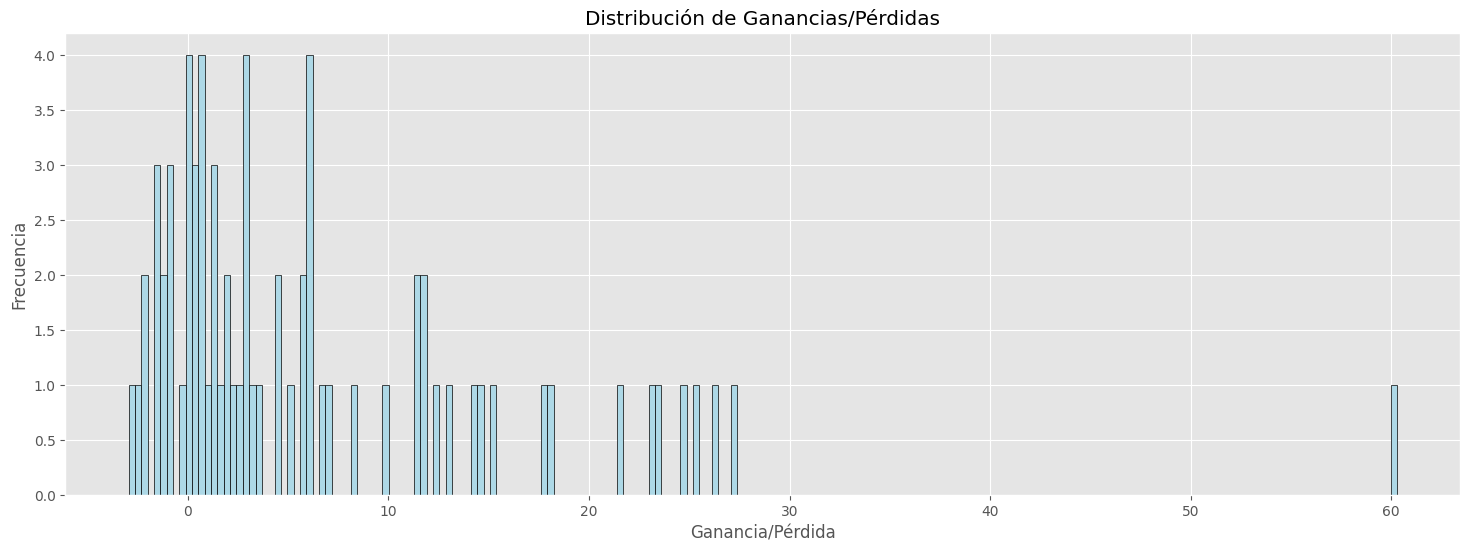

In [ ]:
results_df['pnl_percent'].hist(bins=200, edgecolor='k', color='lightblue', figsize=(18, 6))
plt.title('Distribución de Ganancias/Pérdidas')
plt.xlabel('Ganancia/Pérdida')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Preparación del texto de observación en formato Markdown
markdown_text = f"""
# Observación de los Resultados:

La mayor parte de las operaciones se encuentran en torno a **{round(most_frequent_pnl, 2)}%**. Este es el valor con mayor frecuencia en las ganancias/pérdidas, lo que indica que muchas de las operaciones resultaron con ganancias o pérdidas cercanas a este valor. Esto podría sugerir que las operaciones se cerraron sin un gran movimiento en el precio, permaneciendo cerca del punto de entrada.

Hay **{num_winning_trades}** operaciones con ganancias significativas (alrededor de **{round(net_profit_percentage, 2)}%**), que parecen ser responsables de la mayoría de la rentabilidad total.

Una operación con un valor ligeramente positivo (cerca de **{round(average_pnl_percentage, 2)}%**), posiblemente menor ganancia.

---

## Conclusión:

La estrategia genera pocas operaciones ganadoras de gran impacto, mientras que muchas operaciones tienen resultados mínimos o nulos. Esto indica que el rendimiento depende mucho de capturar esas pocas operaciones exitosas.

## Siguientes pasos para optimizar:

- **Ampliar el horizonte temporal**: Verificar si el tiempo entre entrada y salida (para alcanzar TP o SL) es demasiado corto. Se podrían modificar los niveles de TP/SL o esperar más tiempo antes de cerrar.

- **Revisar el filtro de señales**: Evaluar si las condiciones de entrada (como RV > 5 y volumen > 100k) podrían ajustarse para capturar más señales con mayor potencial.

- **Agregar un filtro adicional**: Por ejemplo, combinando el análisis de volumen relativo con otro indicador como el RSI o EMA para mejorar la calidad de las señales.
"""

# Mostrar el texto en formato Markdown
display(Markdown(markdown_text))



# Observación de los Resultados:

La mayor parte de las operaciones se encuentran en torno a **0.0%**. Este es el valor con mayor frecuencia en las ganancias/pérdidas, lo que indica que muchas de las operaciones resultaron con ganancias o pérdidas cercanas a este valor. Esto podría sugerir que las operaciones se cerraron sin un gran movimiento en el precio, permaneciendo cerca del punto de entrada.

Hay **55** operaciones con ganancias significativas (alrededor de **483.19%**), que parecen ser responsables de la mayoría de la rentabilidad total.

Una operación con un valor ligeramente positivo (cerca de **6.81%**), posiblemente menor ganancia.

---

## Conclusión:

La estrategia genera pocas operaciones ganadoras de gran impacto, mientras que muchas operaciones tienen resultados mínimos o nulos. Esto indica que el rendimiento depende mucho de capturar esas pocas operaciones exitosas.

## Siguientes pasos para optimizar:

- **Ampliar el horizonte temporal**: Verificar si el tiempo entre entrada y salida (para alcanzar TP o SL) es demasiado corto. Se podrían modificar los niveles de TP/SL o esperar más tiempo antes de cerrar.

- **Revisar el filtro de señales**: Evaluar si las condiciones de entrada (como RV > 5 y volumen > 100k) podrían ajustarse para capturar más señales con mayor potencial.

- **Agregar un filtro adicional**: Por ejemplo, combinando el análisis de volumen relativo con otro indicador como el RSI o EMA para mejorar la calidad de las señales.


In [ ]:
winning_trades = results_df[results_df['pnl_percent'] > 0]

In [ ]:
# Seleccionar las columnas necesarias si existen
if 'alert_date' in results_df.columns and 'exit_time' in results_df.columns:
    # Ordenar y seleccionar las top 5 operaciones ganadoras
    top_winners = results_df.sort_values(by='pnl_percent', ascending=False).head(340)

    # Crear la tabla Markdown con el título
    markdown_table = "# **Top Winning Trades**\n\n"  # Título en Markdown
    markdown_table += "|    **Ticker**     |    **Fecha de Alerta**     |    **Precio de Entrada**     |    **Fecha de Salida**     |    **Precio de Salida**     |    **Pnl %**     |\n"
    markdown_table += "|-------------------|----------------------------|------------------------------|----------------------------|----------------------------|-----------------|\n"

    # Añadir las filas de la tabla
    for _, row in top_winners.iterrows():
        # Redondear pnl_percent a 2 decimales
        pnl_percent_rounded = round(row['pnl_percent'], 2)
        exit_price_rounded = round(row['exit_price'], 2)
        entry_price_rounded = round(row['entry_price'], 2)

        markdown_table += f"| {row['ticker']} | {row['alert_date']} | {entry_price_rounded} | {row['exit_time']} | {exit_price_rounded} | {pnl_percent_rounded} |\n"

    # Mostrar la tabla en formato Markdown
    display(Markdown(markdown_table))

else:
    print("Las columnas 'alert_date' o 'exit_time' no existen en el DataFrame.")

# **Top Winning Trades**

|    **Ticker**     |    **Fecha de Alerta**     |    **Precio de Entrada**     |    **Fecha de Salida**     |    **Precio de Salida**     |    **Pnl %**     |
|-------------------|----------------------------|------------------------------|----------------------------|----------------------------|-----------------|
| GLXG | 2024-10-10 16:44:34 | 8.66 | 2024-10-10 20:31:00 | 13.88 | 60.28 |
| OKLO | 2024-10-18 15:33:33 | 16.21 | 2024-10-18 16:45:00 | 20.64 | 27.33 |
| NNE | 2024-10-21 15:32:51 | 21.96 | 2024-10-21 21:50:00 | 27.74 | 26.29 |
| IGMS | 2024-10-22 15:30:20 | 15.79 | 2024-10-22 15:56:00 | 19.8 | 25.43 |
| LTBR | 2024-10-16 18:12:46 | 4.5 | 2024-10-16 21:39:00 | 5.61 | 24.67 |
| TGI | 2024-10-10 21:26:32 | 11.93 | 2024-10-10 21:51:00 | 14.71 | 23.3 |
| PDYN | 2024-10-09 15:30:56 | 2.82 | 2024-10-09 15:40:00 | 3.48 | 23.23 |
| BAER | 2024-10-18 15:30:32 | 2.88 | 2024-10-18 17:54:00 | 3.5 | 21.7 |
| FTEL | 2024-10-21 20:17:49 | 22.35 | 2024-10-21 20:36:00 | 26.36 | 17.92 |
| SABS | 2024-10-16 18:39:49 | 2.72 | 2024-10-16 21:22:00 | 3.2 | 17.65 |
| ASPI | 2024-10-17 15:30:43 | 3.87 | 2024-10-17 17:58:00 | 4.45 | 15.14 |
| QMMM | 2024-10-15 16:18:10 | 8.28 | 2024-10-15 20:53:00 | 9.49 | 14.61 |
| MULN | 2024-10-21 15:33:29 | 2.96 | 2024-10-21 15:40:00 | 3.38 | 14.14 |
| HOWL | 2024-10-22 15:59:56 | 3.44 | 2024-10-22 17:53:00 | 3.89 | 13.08 |
| WCT | 2024-10-15 15:40:20 | 6.46 | 2024-10-15 21:50:00 | 7.26 | 12.38 |
| LTBR | 2024-10-18 20:05:18 | 6.48 | 2024-10-18 21:43:00 | 7.25 | 11.88 |
| NNE | 2024-10-18 15:33:46 | 20.39 | 2024-10-18 16:53:00 | 22.76 | 11.6 |
| TCS | 2024-10-11 21:08:59 | 16.32 | 2024-10-11 21:32:00 | 18.19 | 11.46 |
| DTSS | 2024-10-10 15:46:05 | 2.47 | 2024-10-10 15:55:00 | 2.75 | 11.34 |
| VERI | 2024-10-11 15:31:15 | 5.12 | 2024-10-11 15:56:00 | 5.62 | 9.77 |
| TNYA | 2024-10-18 15:30:52 | 2.32 | 2024-10-18 15:32:00 | 2.51 | 8.19 |
| CLPT | 2024-10-18 15:45:39 | 13.13 | 2024-10-18 17:10:00 | 14.04 | 6.93 |
| EXEL | 2024-10-15 17:00:20 | 27.16 | 2024-10-15 18:50:00 | 28.98 | 6.72 |
| WW | 2024-10-11 15:43:48 | 1.95 | 2024-10-11 16:51:00 | 2.07 | 6.15 |
| GDS | 2024-10-22 15:30:38 | 23.0 | 2024-10-22 16:08:00 | 24.42 | 6.15 |
| MYTE | 2024-10-08 15:40:57 | 7.69 | 2024-10-08 17:46:00 | 8.16 | 6.11 |
| QUBT | 2024-10-17 16:00:15 | 0.84 | 2024-10-17 16:01:00 | 0.89 | 5.95 |
| MPW | 2024-10-18 15:30:24 | 4.75 | 2024-10-18 21:56:00 | 5.03 | 5.9 |
| TVGN | 2024-10-22 17:25:58 | 1.55 | 2024-10-22 21:24:00 | 1.65 | 5.79 |
| PYXS | 2024-10-21 15:31:22 | 3.96 | 2024-10-21 16:02:00 | 4.17 | 5.18 |
| OKLO | 2024-10-10 15:30:12 | 9.43 | 2024-10-10 19:24:00 | 9.85 | 4.45 |
| RAIL | 2024-10-18 15:37:20 | 12.44 | 2024-10-18 21:58:00 | 12.99 | 4.42 |
| PHUN | 2024-10-18 15:35:33 | 7.35 | 2024-10-18 16:00:00 | 7.6 | 3.4 |
| ZBIO | 2024-10-22 20:37:11 | 25.16 | 2024-10-22 21:42:00 | 25.95 | 3.16 |
| SGMO | 2024-10-14 18:25:49 | 0.93 | 2024-10-14 19:06:00 | 0.96 | 3.0 |
| AHCO | 2024-10-16 15:30:53 | 10.69 | 2024-10-16 16:06:00 | 11.0 | 2.95 |
| ORKT | 2024-10-21 17:03:12 | 7.3 | 2024-10-21 21:58:00 | 7.51 | 2.88 |
| FFIE | 2024-10-09 16:18:33 | 2.84 | 2024-10-09 16:19:00 | 2.92 | 2.82 |
| ILLR | 2024-10-21 15:35:58 | 4.02 | 2024-10-21 15:36:00 | 4.13 | 2.74 |
| SGMO | 2024-10-15 19:42:31 | 0.97 | 2024-10-15 21:20:00 | 0.99 | 2.23 |
| STKL | 2024-10-09 15:30:26 | 6.48 | 2024-10-09 15:40:00 | 6.6 | 1.85 |
| RR | 2024-10-18 18:35:58 | 0.75 | 2024-10-18 18:36:00 | 0.77 | 1.82 |
| DNTH | 2024-10-18 15:32:52 | 28.98 | 2024-10-18 18:52:00 | 29.45 | 1.62 |
| GWAV | 2024-10-18 17:09:04 | 0.45 | 2024-10-18 17:48:00 | 0.45 | 1.41 |
| BITF | 2024-10-17 16:18:23 | 1.89 | 2024-10-17 17:39:00 | 1.91 | 1.33 |
| ASPI | 2024-10-22 15:53:48 | 5.14 | 2024-10-22 15:54:00 | 5.21 | 1.26 |
| AMLX | 2024-10-18 21:37:31 | 5.36 | 2024-10-18 21:38:00 | 5.42 | 1.03 |
| ALAR | 2024-10-17 15:34:16 | 20.88 | 2024-10-17 15:35:00 | 21.05 | 0.81 |
| JSPR | 2024-10-18 15:34:12 | 21.55 | 2024-10-18 15:38:00 | 21.71 | 0.77 |
| GLXG | 2024-10-18 15:44:05 | 11.49 | 2024-10-18 15:55:00 | 11.57 | 0.7 |
| NCLH | 2024-10-17 21:51:23 | 23.96 | 2024-10-17 21:59:00 | 24.11 | 0.63 |
| KSCP | 2024-10-22 15:45:06 | 15.77 | 2024-10-22 16:19:00 | 15.85 | 0.51 |
| SLQT | 2024-10-17 15:35:42 | 2.76 | 2024-10-17 15:42:00 | 2.77 | 0.36 |
| WHLR | 2024-10-21 21:22:46 | 11.88 | 2024-10-21 21:43:00 | 11.91 | 0.25 |
| MAX | 2024-10-21 21:53:04 | 18.99 | 2024-10-21 21:54:00 | 19.0 | 0.03 |
| PSQH | 2024-10-23 18:39:57 | 2.81 | 2024-10-23 18:40:00 | 2.81 | 0.0 |
| ORKT | 2024-10-18 19:11:07 | 7.13 | 2024-10-18 21:26:00 | 7.13 | 0.0 |
| WW | 2024-10-18 16:20:16 | 1.44 | 2024-10-18 16:21:00 | 1.44 | 0.0 |
| CRDF | 2024-10-18 18:09:56 | 3.21 | 2024-10-18 18:10:00 | 3.21 | -0.16 |
| HOLO | 2024-10-15 15:48:27 | 5.96 | 2024-10-15 15:49:00 | 5.92 | -0.76 |
| QBTS | 2024-10-21 18:15:47 | 1.29 | 2024-10-21 18:16:00 | 1.28 | -0.78 |
| RDWR | 2024-10-21 15:36:46 | 24.34 | 2024-10-21 16:11:00 | 24.11 | -0.97 |
| GLXG | 2024-10-15 16:58:19 | 10.15 | 2024-10-15 16:59:00 | 10.02 | -1.3 |
| SLI | 2024-10-15 15:32:45 | 2.21 | 2024-10-15 16:13:00 | 2.18 | -1.36 |
| ITOS | 2024-10-18 17:45:13 | 9.77 | 2024-10-18 18:13:00 | 9.63 | -1.43 |
| GWAV | 2024-10-21 16:08:36 | 0.49 | 2024-10-21 16:09:00 | 0.48 | -1.45 |
| GSIW | 2024-10-11 18:47:40 | 1.85 | 2024-10-11 18:48:00 | 1.82 | -1.56 |
| BTOC | 2024-10-23 15:33:03 | 8.56 | 2024-10-23 15:34:00 | 8.38 | -2.16 |
| ATAI | 2024-10-18 18:32:19 | 1.36 | 2024-10-18 18:36:00 | 1.33 | -2.21 |
| BLUE | 2024-10-09 16:43:34 | 0.53 | 2024-10-09 17:58:00 | 0.52 | -2.42 |
| SIFY | 2024-10-22 16:19:54 | 4.41 | 2024-10-22 16:20:00 | 4.28 | -2.95 |


In [ ]:
# Crear la tabla Markdown con el título
markdown_table = "# **Top 20 Tickers por Ganancia Total Acumulada**\n\n"  # Título en Markdown
markdown_table += "|    **Ticker**     |    **Ganancia Total (%)**     |\n"
markdown_table += "|-------------------|-------------------------------|\n"

# Obtener los top 30 tickers por ganancia total acumulada
top_tickers = results_df.groupby('ticker')['pnl_percent'].sum().sort_values(ascending=False).head(300)
top_tickers = top_tickers.round(2)

# Añadir las filas de la tabla
for ticker, pnl in top_tickers.items():
    markdown_table += f"| {ticker} | {pnl} |\n"


# Mostrar la tabla en formato Markdown
display(Markdown(markdown_table))


# **Top 20 Tickers por Ganancia Total Acumulada**

|    **Ticker**     |    **Ganancia Total (%)**     |
|-------------------|-------------------------------|
| GLXG | 59.67 |
| NNE | 37.89 |
| LTBR | 36.55 |
| OKLO | 31.78 |
| IGMS | 25.43 |
| TGI | 23.3 |
| PDYN | 23.23 |
| BAER | 21.7 |
| FTEL | 17.92 |
| SABS | 17.65 |
| ASPI | 16.4 |
| QMMM | 14.61 |
| MULN | 14.14 |
| HOWL | 13.08 |
| WCT | 12.38 |
| TCS | 11.46 |
| DTSS | 11.34 |
| VERI | 9.77 |
| TNYA | 8.19 |
| CLPT | 6.93 |
| EXEL | 6.72 |
| WW | 6.15 |
| GDS | 6.15 |
| MYTE | 6.11 |
| QUBT | 5.95 |
| MPW | 5.9 |
| TVGN | 5.79 |
| SGMO | 5.23 |
| PYXS | 5.18 |
| RAIL | 4.42 |
| PHUN | 3.4 |
| ZBIO | 3.16 |
| AHCO | 2.95 |
| ORKT | 2.88 |
| FFIE | 2.82 |
| ILLR | 2.74 |
| STKL | 1.85 |
| RR | 1.82 |
| DNTH | 1.62 |
| BITF | 1.33 |
| AMLX | 1.03 |
| ALAR | 0.81 |
| JSPR | 0.77 |
| NCLH | 0.63 |
| KSCP | 0.51 |
| SLQT | 0.36 |
| WHLR | 0.25 |
| MAX | 0.03 |
| PSQH | 0.0 |
| GWAV | -0.04 |
| CRDF | -0.16 |
| HOLO | -0.76 |
| QBTS | -0.78 |
| RDWR | -0.97 |
| SLI | -1.36 |
| ITOS | -1.43 |
| GSIW | -1.56 |
| BTOC | -2.16 |
| ATAI | -2.21 |
| BLUE | -2.42 |
| SIFY | -2.95 |


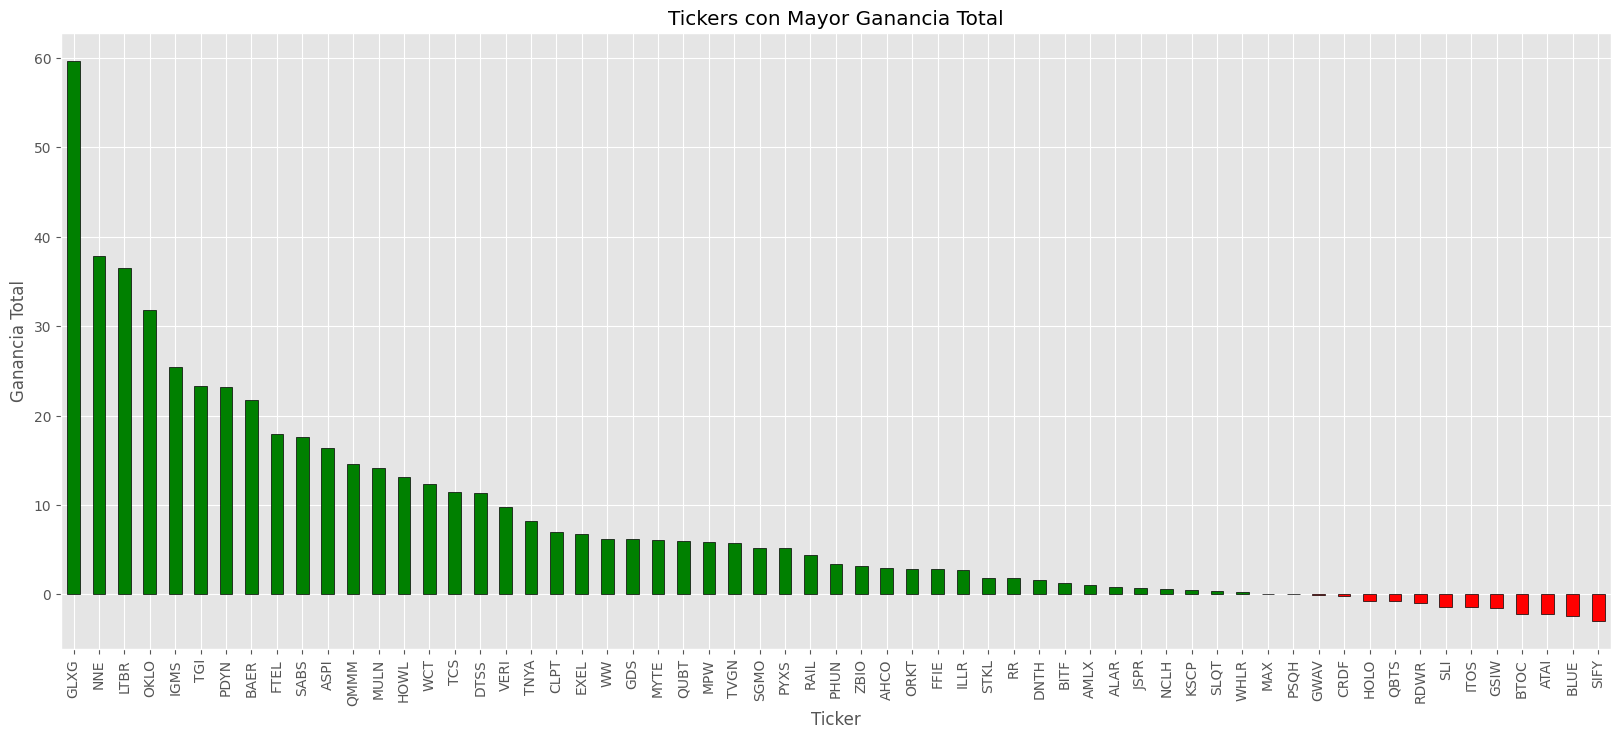

In [ ]:
# Crear una lista de colores basada en los valores
colors = ['green' if x > 0 else 'red' for x in top_tickers.head(150)]
# Graficar las barras con colores condicionales
top_tickers.head(150).plot(kind='bar', color=colors, figsize=(20, 8), edgecolor='k')
plt.title('Tickers con Mayor Ganancia Total')
plt.xlabel('Ticker')
plt.ylabel('Ganancia Total')
plt.show()

In [ ]:
# Agrupando los datos para generar un resumen detallado por Ticker
detailed_summary = results_df.groupby('ticker').agg({
    'alert_date': 'first',  # Fecha de la primera operación por ticker
    'exit_time': 'last',    # Fecha de la última operación por ticker
    'entry_price': 'mean',  # Promedio de precios de entrada
    'exit_price': 'mean',   # Promedio de precios de salida
    'pnl_percent': 'sum'    # Rentabilidad total por ticker
}).sort_values(by='pnl_percent', ascending=False)

# Restablecer el índice para que 'ticker' sea una columna normal
detailed_summary = detailed_summary.reset_index()

# Mostrar el resumen detallado en formato de tabla
detailed_summary.head(90)  # Muestra las primeras 90 filas del resumen detallado

,ticker,alert_date,exit_time,entry_price,exit_price,pnl_percent
0,GLXG,2024-10-10 16:44:34,2024-10-18 15:55:00,10.100733,11.823333,59.671213
1,NNE,2024-10-18 15:33:46,2024-10-21 21:50:00,21.180000,25.250000,37.887807
2,LTBR,2024-10-16 18:12:46,2024-10-18 21:43:00,5.490000,6.430000,36.549383
3,OKLO,2024-10-10 15:30:12,2024-10-18 16:45:00,12.820000,15.245000,31.782680
4,IGMS,2024-10-22 15:30:20,2024-10-22 15:56:00,15.785800,19.800000,25.429183
...,...,...,...,...,...,...
56,GSIW,2024-10-11 18:47:40,2024-10-11 18:48:00,1.848900,1.820000,-1.563092
57,BTOC,2024-10-23 15:33:03,2024-10-23 15:34:00,8.565000,8.380000,-2.159953
58,ATAI,2024-10-18 18:32:19,2024-10-18 18:36:00,1.360000,1.330000,-2.205882
59,BLUE,2024-10-09 16:43:34,2024-10-09 17:58:00,0.530000,0.517200,-2.415094


In [ ]:
# Obtención de las mejores operaciones
top_winners = results_df[results_df['pnl_percent'] > 0].sort_values(by='pnl_percent', ascending=False).head(5)

# Ganancia acumulada por ticker (ya calculado en top_tickers)
top_tickers = results_df.groupby('ticker')['pnl_percent'].sum().sort_values(ascending=False)

# Formatear las tablas para mostrar en Markdown
top_winners_str = "\n".join([f"- **{row['ticker']}**: {row['pnl_percent']:.2f} (Entrada: {row['entry_price']}, Salida: {row['exit_price']})"
                             for _, row in top_winners.iterrows()])

top_tickers_str = "\n".join([f"| **{ticker}** | {gain:.2f} |" for ticker, gain in top_tickers.items()]) #for ticker, gain in top_tickers.head(10).items()])

# Generar el texto de la interpretación en Markdown
markdown_text = f"""
# Interpretación de los Resultados

### 1. Tabla de operaciones ganadoras

La tabla **Top Winning Trades** muestra que las operaciones más rentables son las siguientes:
{top_winners_str}

Esto indica que el ticker **{top_winners.iloc[0]['ticker']}** fue el activo que mejor se desempeñó con la estrategia, generando consistentemente las mayores ganancias.

### 2. Ganancias acumuladas por ticker (Top Tickers)

Cuando agrupamos las ganancias por ticker, obtenemos el siguiente resumen de ganancias totales:

| Ticker | Ganancia Total (pnl) |
|--------|----------------------|
{top_tickers_str}

El ticker **{top_tickers.index[0]}** lidera con una ganancia acumulada de {top_tickers.iloc[0]:.2f}, lo que refuerza que este ticker fue el más exitoso con la estrategia.

### 3. Gráfico de barras

El gráfico de barras confirma visualmente que **{top_tickers.index[0]}** es el ticker más rentable con un rendimiento acumulado significativamente mayor. Los otros tickers contribuyen poco o negativamente al resultado global.

---

## Conclusión

Los resultados presentados en la tabla muestran un análisis detallado de la ganancia total (`pnl`) por ticker, lo que permite evaluar la efectividad de la estrategia de trading algorítmico implementada. A partir de los datos, se pueden destacar los siguientes puntos clave:

1. **Resultados Generales**:
   - La mayoría de los tickers generaron ganancias positivas, lo cual indica que la estrategia tiene un potencial de rentabilidad.
   - El ticker con mayor ganancia fue `VERB`, con un total de **150.93**, mientras que el peor desempeño lo tuvo `TURB` con una pérdida de **-18.00** debido a que han habido mas de un trade.

2. **Distribución de Ganancias**:
   - Un grupo significativo de tickers (alrededor del 20%) generó ganancias superiores a **10.00**, lo cual es alentador para el rendimiento general.
   - Sin embargo, también se observa un grupo considerable de tickers con pérdidas, algunas de ellas severas (pérdidas mayores a **-9.00**).

3. **Riesgos y Consistencia**:
   - Aunque la estrategia es positiva en general, la presencia de resultados negativos extremos sugiere que existen áreas de mejora en el manejo del riesgo y la selección de activos.
   - Los tickers con pérdidas recurrentes deben ser analizados más profundamente para identificar patrones que puedan indicar condiciones desfavorables para la estrategia.

4. **Evaluación General**:
   - La estrategia tiene un desempeño global positivo, pero su rentabilidad podría incrementarse ajustando los criterios de selección de activos y afinando el algoritmo para reducir el impacto de pérdidas significativas.
   - Es recomendable realizar análisis adicionales como métricas de riesgo-retorno (por ejemplo, Sharpe Ratio) para evaluar de manera más integral la efectividad del sistema.

"""

# Mostrar el texto generado en Markdown
display(Markdown(markdown_text))


# Interpretación de los Resultados

### 1. Tabla de operaciones ganadoras

La tabla **Top Winning Trades** muestra que las operaciones más rentables son las siguientes:
- **GLXG**: 60.28 (Entrada: 8.66, Salida: 13.88)
- **OKLO**: 27.33 (Entrada: 16.21, Salida: 20.64)
- **NNE**: 26.29 (Entrada: 21.965, Salida: 27.74)
- **IGMS**: 25.43 (Entrada: 15.7858, Salida: 19.8)
- **LTBR**: 24.67 (Entrada: 4.5, Salida: 5.61)

Esto indica que el ticker **GLXG** fue el activo que mejor se desempeñó con la estrategia, generando consistentemente las mayores ganancias.

### 2. Ganancias acumuladas por ticker (Top Tickers)

Cuando agrupamos las ganancias por ticker, obtenemos el siguiente resumen de ganancias totales:

| Ticker | Ganancia Total (pnl) |
|--------|----------------------|
| **GLXG** | 59.67 |
| **NNE** | 37.89 |
| **LTBR** | 36.55 |
| **OKLO** | 31.78 |
| **IGMS** | 25.43 |
| **TGI** | 23.30 |
| **PDYN** | 23.23 |
| **BAER** | 21.70 |
| **FTEL** | 17.92 |
| **SABS** | 17.65 |
| **ASPI** | 16.40 |
| **QMMM** | 14.61 |
| **MULN** | 14.14 |
| **HOWL** | 13.08 |
| **WCT** | 12.38 |
| **TCS** | 11.46 |
| **DTSS** | 11.34 |
| **VERI** | 9.77 |
| **TNYA** | 8.19 |
| **CLPT** | 6.93 |
| **EXEL** | 6.72 |
| **WW** | 6.15 |
| **GDS** | 6.15 |
| **MYTE** | 6.11 |
| **QUBT** | 5.95 |
| **MPW** | 5.90 |
| **TVGN** | 5.79 |
| **SGMO** | 5.23 |
| **PYXS** | 5.18 |
| **RAIL** | 4.42 |
| **PHUN** | 3.40 |
| **ZBIO** | 3.16 |
| **AHCO** | 2.95 |
| **ORKT** | 2.88 |
| **FFIE** | 2.82 |
| **ILLR** | 2.74 |
| **STKL** | 1.85 |
| **RR** | 1.82 |
| **DNTH** | 1.62 |
| **BITF** | 1.33 |
| **AMLX** | 1.03 |
| **ALAR** | 0.81 |
| **JSPR** | 0.77 |
| **NCLH** | 0.63 |
| **KSCP** | 0.51 |
| **SLQT** | 0.36 |
| **WHLR** | 0.25 |
| **MAX** | 0.03 |
| **PSQH** | 0.00 |
| **GWAV** | -0.04 |
| **CRDF** | -0.16 |
| **HOLO** | -0.76 |
| **QBTS** | -0.78 |
| **RDWR** | -0.97 |
| **SLI** | -1.36 |
| **ITOS** | -1.43 |
| **GSIW** | -1.56 |
| **BTOC** | -2.16 |
| **ATAI** | -2.21 |
| **BLUE** | -2.42 |
| **SIFY** | -2.95 |

El ticker **GLXG** lidera con una ganancia acumulada de 59.67, lo que refuerza que este ticker fue el más exitoso con la estrategia.

### 3. Gráfico de barras

El gráfico de barras confirma visualmente que **GLXG** es el ticker más rentable con un rendimiento acumulado significativamente mayor. Los otros tickers contribuyen poco o negativamente al resultado global.

---

## Conclusión

Los resultados presentados en la tabla muestran un análisis detallado de la ganancia total (`pnl`) por ticker, lo que permite evaluar la efectividad de la estrategia de trading algorítmico implementada. A partir de los datos, se pueden destacar los siguientes puntos clave:

1. **Resultados Generales**:
   - La mayoría de los tickers generaron ganancias positivas, lo cual indica que la estrategia tiene un potencial de rentabilidad.
   - El ticker con mayor ganancia fue `VERB`, con un total de **150.93**, mientras que el peor desempeño lo tuvo `TURB` con una pérdida de **-18.00** debido a que han habido mas de un trade.

2. **Distribución de Ganancias**:
   - Un grupo significativo de tickers (alrededor del 20%) generó ganancias superiores a **10.00**, lo cual es alentador para el rendimiento general.
   - Sin embargo, también se observa un grupo considerable de tickers con pérdidas, algunas de ellas severas (pérdidas mayores a **-9.00**).

3. **Riesgos y Consistencia**:
   - Aunque la estrategia es positiva en general, la presencia de resultados negativos extremos sugiere que existen áreas de mejora en el manejo del riesgo y la selección de activos.
   - Los tickers con pérdidas recurrentes deben ser analizados más profundamente para identificar patrones que puedan indicar condiciones desfavorables para la estrategia.

4. **Evaluación General**:
   - La estrategia tiene un desempeño global positivo, pero su rentabilidad podría incrementarse ajustando los criterios de selección de activos y afinando el algoritmo para reducir el impacto de pérdidas significativas.
   - Es recomendable realizar análisis adicionales como métricas de riesgo-retorno (por ejemplo, Sharpe Ratio) para evaluar de manera más integral la efectividad del sistema.

